{0: 0, 1: 1, 5: 1, 12: 1, 13: 2, 14: 3, 11: 4, 9: 13, 6: 7, 7: 8, 3: 12, 2: 0, 4: 0, 8: 0, 10: 0}
{0: (-4.0, 13), 2: (-2.0, 13), 4: (0.0, 13), 8: (2.0, 13), 10: (4.0, 13), 1: (-2.6666666666666665, 12), 5: (0.0, 12), 12: (2.6666666666666665, 12), 13: (0.6714996690725679, 11), 14: (0.7373393701025619, 10), 11: (-7.37365897469644e-05, 9), 6: (-0.878323655565852, 6), 7: (-1.0744216456923334, 5), 3: (0.9254559064486707, 1), 9: (-0.8964973641105961, 0)}


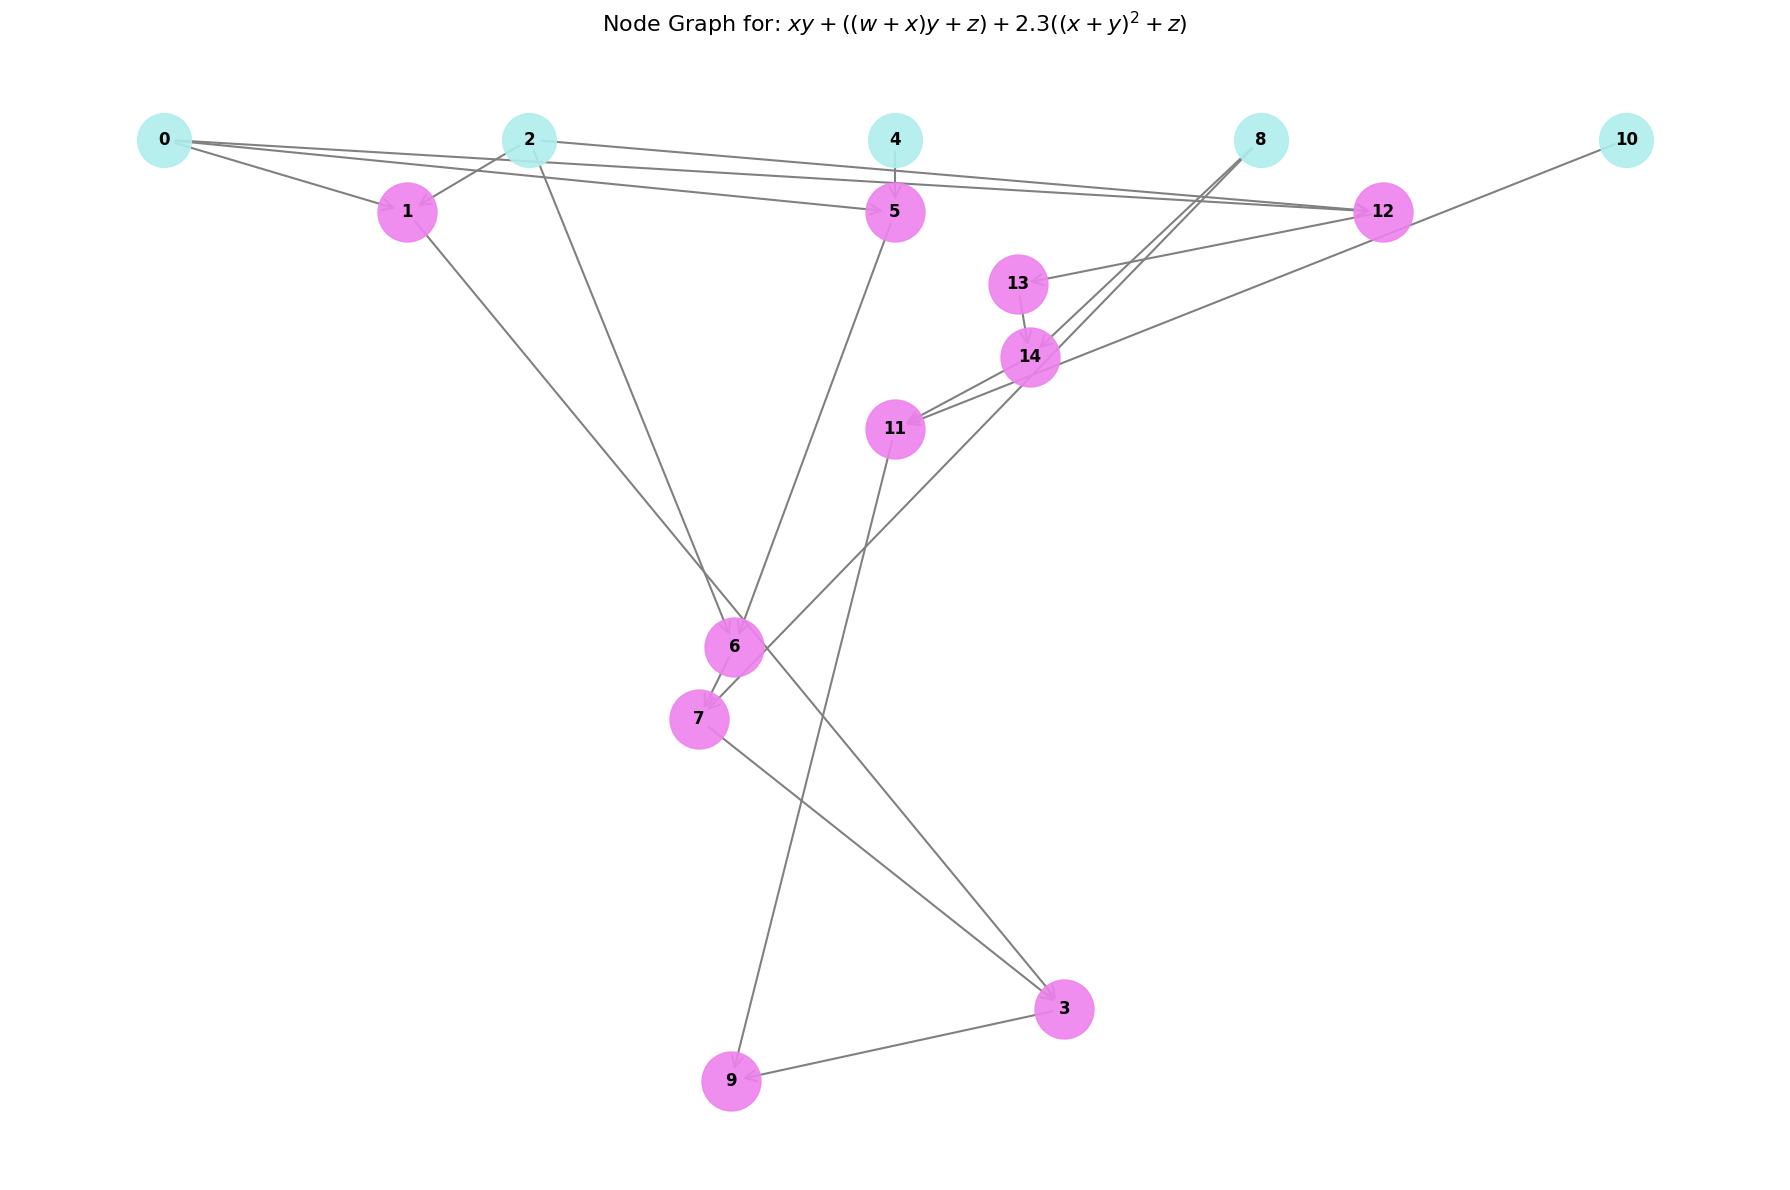

In [77]:
import sympy as sp
import networkx as nx
import matplotlib.pyplot as plt
from sympy.parsing.sympy_parser import parse_expr, standard_transformations, implicit_multiplication_application
from collections import deque, defaultdict
import numpy as np
import random
import ast


class PolynomialParser(ast.NodeVisitor):
    def visit_BinOp(self, node):
        left = self.visit(node.left)
        right = self.visit(node.right)
        op = type(node.op)

        if op == ast.Add:
            return sp.Add(left, right, evaluate=False)
        elif op == ast.Mult:
            return sp.Mul(left, right, evaluate=False)
        elif op == ast.Pow:
            return sp.Pow(left, right, evaluate=False)

    
    def visit_Name(self, node):
        return sp.Symbol(node.id)

    def visit_Constant(self, node): 
        return sp.Number(node.value)

    def visit_Expr(self, node):
        return self.visit(node.value)

    def parse(self, expression):
        tree = ast.parse(expression, mode='eval')
        return self.visit(tree.body)

# Parse a sympy expression and build a node graph showing operations
def create_node_graph(expr):
    graph = nx.DiGraph()
    node_id = 0
    node_id, root_id = process_expression(expr, graph, node_id)
    return graph, root_id


# Process the expression recursively
def process_expression(expr, graph, node_id, parent_id=None, top_level=False, expr_to_id=None):
    if expr_to_id is None:
        expr_to_id = {}
    
    # Checks if the exact expression has been processed and does not add it if so
    # Uses hash to create a unique key for each expression element
    expr_hash = hash(expr)
    if expr_hash in expr_to_id:
        node_for_expr = expr_to_id[expr_hash]
        if parent_id is not None:
            graph.add_edge(node_for_expr, parent_id)

        return node_id, node_for_expr
    
    if isinstance(expr, sp.Add) or isinstance(expr, sp.Mul):
        args = list(expr.args)
        if top_level:
            # if top_level = True the first time this function executes, there is a non binary addition as the last addition in the sequence of polynomials
            add_node = node_id
            graph.add_node(add_node, label="+" if isinstance(expr, sp.Add) else r"$\cdot$", type="operation")
            expr_to_id[expr_hash] = add_node
            node_id += 1
            for term in args:
                node_id, child_id = process_expression(term, graph, node_id, top_level=False, expr_to_id=expr_to_id)
                graph.add_edge(child_id, add_node)
            if parent_id is not None:
                graph.add_edge(add_node, parent_id)
            return node_id, add_node
        else:
            label = "+" if isinstance(expr, sp.Add) else r"$\cdot$"
            # Creates a binary tree
            left_expr = args[0]
            node_id, left_id = process_expression(left_expr, graph, node_id, top_level=False, expr_to_id=expr_to_id)
    
            for expr_branch in args[1:]:
                parent_node = node_id
                graph.add_node(parent_node, label=label, type="operation")
                expr_to_id[expr_hash] = parent_node
                node_id += 1
    
                # Connect to the parent node
                if parent_id is not None:
                    graph.add_edge(parent_node, parent_id)
                    parent_id = parent_node 
    
                # Left branch
                graph.add_edge(left_id, parent_node)
    
                # Right branch
                node_id, right_id = process_expression(expr_branch, graph, node_id, top_level=False, expr_to_id=expr_to_id)
                graph.add_edge(right_id, parent_node)
    
                left_id = parent_node  # for chaining
    
            return node_id, left_id
    elif isinstance(expr, sp.Pow):
        base, exp = expr.args
        # Assumes that exponent is an integer
        if exp.is_Integer and exp > 1:
            # Process the base expression once
            node_id, base_id = process_expression(base, graph, node_id, top_level=False, expr_to_id=expr_to_id)
            
            # Create the power node
            pow_node = node_id
            graph.add_node(pow_node, label=f"^{exp}", type="operation")
            expr_to_id[expr_hash] = pow_node
            node_id += 1
            
            # Connect the nodes
            graph.add_edge(base_id, pow_node)
            
            if parent_id is not None:
                graph.add_edge(pow_node, parent_id)
                
            return node_id, pow_node
            
    elif isinstance(expr, sp.Symbol):
        curr_id = node_id
        graph.add_node(curr_id, label=str(expr), type="value")
        expr_to_id[expr_hash] = curr_id
        node_id += 1
        if parent_id is not None:
            graph.add_edge(curr_id, parent_id)
        return node_id, curr_id
    elif expr.is_number:
        curr_id = node_id
        graph.add_node(curr_id, label=str(round(expr, 2)), type="value")
        expr_to_id[expr_hash] = curr_id
        node_id += 1
        if parent_id is not None:
            graph.add_edge(curr_id, parent_id)
        return node_id, curr_id



# Orders nodes based on stages starting from the symbolic characters
def stage_levels(G, node):
    levels = {}
    for node in G.nodes():
        queue = [node]
        layer = 0
    
        #Nodes that have nothing pointing to them, set level to 0
        in_degree = G.in_degree(node)
    
        if in_degree == 0:
            levels[node] = layer
            layer += 1
        
            #Connected nodes have layer one higher
            while queue:
                for i in list(G.successors(queue.pop())):
                    if i in levels.keys():
                        if levels[i] < layer:
                            levels[i] = layer
                    else:
                        levels[i] = layer
                    
                    queue.append(i)
                layer += 1
    print(levels)
    return levels

def math_levels(G, root):
    nodes_math_level = {}
    added_levels = 0
    
    nodes_by_level = organise_nodes_by_level(stage_levels(G, root))
    for level, nodes in nodes_by_level.items():
        if level == 0:
            for j in nodes:
                nodes_math_level[j] = level
        else:
            if not all(G.nodes[nodes[0]]['label'] == G.nodes[x]['label'] for x in nodes):
                added_levels += 1
                for j in nodes:
                    if(G.nodes[j]['label'] == '+'):
                        nodes_math_level[j] = level + added_levels - 1
                    elif(G.nodes[j]['label'] == '$\\cdot$'):
                        nodes_math_level[j] = level + added_levels
            else:
                for k in nodes:
                    nodes_math_level[k] = level + added_levels

    return nodes_math_level

def organise_nodes_by_level(levels):
    nodes_by_level = {}
    
    for node, level in levels.items():
        if level not in nodes_by_level:
            nodes_by_level[level] = []
        nodes_by_level[level].append(node)

    return {k: v for k, v in sorted(nodes_by_level.items())}

def custom_layout(G, root):
    pos = {}
    
    levels = stage_levels(G, root)
    #levels = math_levels(G, root)
    nodes_by_level = organise_nodes_by_level(levels)
    
        
   
    
    for level in nodes_by_level:
        nodes_by_level[level].sort(key=lambda n: (G.nodes[n].get('type', ''), G.nodes[n].get('label', '')))
    
    max_level = max(nodes_by_level)
    spacing = 2 
    
    for level, nodes in nodes_by_level.items():
        num_nodes = len(nodes)
        
        if level == 0:
            max_span = (num_nodes - 1) * spacing    
            x_start = -max_span / 2
            for i, node in enumerate(sorted(nodes)):
                x = x_start + i * spacing
                y = max_level - level
                pos[node] = (x, y)
                
        else:
            if(num_nodes == 1):
                x_start =  random.uniform(-1.5, 1.5)
            else:
                span = (num_nodes - 1) * (max_span/num_nodes)
                x_start = - span/ 2
                
            for i, node in enumerate(sorted(nodes)):
                x = x_start + i * (max_span/num_nodes)
                y = max_level - level
                pos[node] = (x, y)     
    print(pos)
    
    return pos
    
    

def visualize_polynomial(polynomial_str):
    # Parse the expression
    parser = PolynomialParser()
    expr = parser.parse(polynomial_str)
    graph, root_id = create_node_graph(expr)
    node_labels = nx.get_node_attributes(graph, 'label')
    pos = custom_layout(graph, root_id)
    
    plt.figure(figsize=(18, 12))
    
    #Divide up the nodes
    operation_nodes = [n for n in graph.nodes() if graph.nodes[n].get('type') == 'operation']
    value_nodes = [n for n in graph.nodes() if graph.nodes[n].get('type') == 'value']

    
    nx.draw_networkx_nodes(graph, pos, nodelist=operation_nodes, 
                        node_size=1800, node_color='violet', alpha=0.9)
    
    nx.draw_networkx_nodes(graph, pos, nodelist=value_nodes,
                        node_size=1500, node_color='paleturquoise', alpha=0.9)
    
    nx.draw_networkx_edges(graph, pos, arrows=True, arrowstyle='->', 
                          arrowsize=20, width=1.5, edge_color='gray')
    
    node_id_labels = {node: str(node) for node in graph.nodes()}
    nx.draw_networkx_labels(graph, pos, labels=node_id_labels, font_size=12, font_weight='bold')
    #nx.draw_networkx_labels(graph, pos, labels=node_labels, font_size=14, font_weight='bold')
    
    plt.title(f"Node Graph for: ${(polynomial_str.replace('**', '^')).replace('*', '')}$", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show() 

    return graph, root_id


#user_input = input("\nEnter a polynomial: ")
user_input = "x^2 + 4*x^2 + 5.3*((x*y) + z) + 1.01*(x+z) + 1.3*(x+ y) + 2.1*((x+y)^2 + z)"
#user_input = "3.2*(x*(4.2*(x*1.2*(x+1)+2)+4)+5)"
user_input = "x*y + ((w+x)*y + z) + 2.3*((x+y)^2 + z)"
# user_input = "z^2 + (w+x)*y + z"
# user_input = "(z+1)*z + (w+x)*y"

if user_input.strip():
    user_input = user_input.replace('^', '**')
    G, root = visualize_polynomial(user_input)


In [ ]:
levels = {}
for node in G.nodes():
    queue = [node]
    layer = 0

    #Nodes that have nothing pointing to them, set level to 0
    in_degree = G.in_degree(node)

    if in_degree == 0:
        levels[node] = layer
        print(levels)
        layer = 1
    
        #Connected nodes have layer one higher
        while queue:
            print("layer: ", layer)
            print(queue)
            for i in list(G.successors(queue.pop())):
                if i in levels.keys():
                    print("in")
                    if levels[i] < layer:
                        levels[i] = layer
                else:
                    levels[i] = layer
                print(levels)
                
                queue.append(i)
            layer += 1

print(levels)


{0: 0}
layer:  1
[0]
{0: 0, 1: 1}
{0: 0, 1: 1, 5: 1}
{0: 0, 1: 1, 5: 1, 12: 1}
layer:  2
[1, 5, 12]
{0: 0, 1: 1, 5: 1, 12: 1, 13: 2}
layer:  3
[1, 5, 13]
{0: 0, 1: 1, 5: 1, 12: 1, 13: 2, 14: 3}
layer:  4
[1, 5, 14]
{0: 0, 1: 1, 5: 1, 12: 1, 13: 2, 14: 3, 11: 4}
layer:  5
[1, 5, 11]
{0: 0, 1: 1, 5: 1, 12: 1, 13: 2, 14: 3, 11: 4, 9: 5}
layer:  6
[1, 5, 9]
layer:  7
[1, 5]
{0: 0, 1: 1, 5: 1, 12: 1, 13: 2, 14: 3, 11: 4, 9: 5, 6: 7}
layer:  8
[1, 6]
{0: 0, 1: 1, 5: 1, 12: 1, 13: 2, 14: 3, 11: 4, 9: 5, 6: 7, 7: 8}
layer:  9
[1, 7]
{0: 0, 1: 1, 5: 1, 12: 1, 13: 2, 14: 3, 11: 4, 9: 5, 6: 7, 7: 8, 3: 9}
layer:  10
[1, 3]
in
{0: 0, 1: 1, 5: 1, 12: 1, 13: 2, 14: 3, 11: 4, 9: 5, 6: 7, 7: 8, 3: 9}
layer:  11
[1, 9]
layer:  12
[1]
in
{0: 0, 1: 1, 5: 1, 12: 1, 13: 2, 14: 3, 11: 4, 9: 5, 6: 7, 7: 8, 3: 9}
layer:  13
[3]
in
{0: 0, 1: 1, 5: 1, 12: 1, 13: 2, 14: 3, 11: 4, 9: 5, 6: 7, 7: 8, 3: 9}
layer:  14
[9]
{0: 0, 1: 1, 5: 1, 12: 1, 13: 2, 14: 3, 11: 4, 9: 5, 6: 7, 7: 8, 3: 9, 2: 0}
layer:  1
[2]
in
{

In [83]:
levels[2]

0